## GW190412-like signal

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy

from pycbc import conversions, psd
from pycbc.filter import match

from simple_pe.param_est import metric
from pesummary.utils.samples_dict import SamplesDict
from pesummary.gw.conversions import convert

In [2]:
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

In [3]:
def generate_ellipse(g, projected=False, r = 1, npts = 100):
    
    if projected:
        dx_dirs = g.projected_directions
        n_evec = g.projected_evecs()
    else:
        dx_dirs = g.dx_directions
        n_evec = g.normalized_evecs()
        
    if len(dx_dirs) != 2:
        print("We're expecting to plot a 2-d ellipse")
        return -1
    
    # generate points on a circle
    phi = np.linspace(0, 2*np.pi, npts)
    xx = r * np.cos(phi)
    yy = r * np.sin(phi)
    pts = np.array([xx, yy])
    
    # project onto eigendirections
    dx = SamplesDict(dx_dirs, np.matmul(n_evec,pts))
    
    # scale to be physical
    alphas = np.zeros(npts)
    for i in range(npts):
        alphas[i] = metric.check_physical(g.x, dx[i:i+1],1.)

    ellipseDict = SamplesDict(dx_dirs, 
                              np.array([g.x[dx] for dx in dx_dirs]).reshape([2,1]) + dx.samples * alphas)
    
    return ellipseDict

In [4]:
def match_grid(g, projected=False, lim = 1.1, npts = 11):
    
    if projected:
        dx_dirs = g.projected_directions + [x for x in g_3d.dx_directions if x not in g_3d.projected_directions]
        n_evec = g.projected_evecs()
    else:
        dx_dirs = g.dx_directions
        n_evec = g.normalized_evecs()
    
    grid = np.mgrid[-lim:lim:npts*1j,-lim:lim:npts*1j]
    dx_data = np.tensordot(n_evec, grid, axes=(1,0))
    
    if projected:
        dx_extra = np.tensordot(g.projection, dx_data, axes=(1,0))
        dx_data = np.append(dx_data, dx_extra, 0)

    dx = SamplesDict(dx_dirs, dx_data.reshape(len(dx_dirs), npts**2))
    
    nsamp = dx.number_of_samples
    m = np.zeros(nsamp)

    h0 = metric.make_waveform(g.x, g.x, 0., 1., g.psd.delta_f, g.f_low, len(g.psd), g.approximant)

    for i in range(nsamp):
        if metric.check_physical(g.x, dx[i:i+1],1.) < 1:
            m[i] = 0
        else:
            h1 = metric.make_waveform(params, dx[i:i+1], 1., 1., g.psd.delta_f, g.f_low, len(g.psd), g.approximant)
            m[i] = match(h0, h1, g.psd, g.f_low)[0]
            
    matches = SamplesDict(dx_dirs + ['match'], 
                          np.append(dx.samples  + np.array([g.x[dx] for dx in dx_dirs]).reshape([len(dx_dirs),1]), 
                                    m.reshape([1,npts**2]), 0).reshape(len(dx_dirs)+1, npts, npts))
    
    return matches

## Read in PSDs, etc

In [5]:
ifos = ['H1', 'L1', 'V1']

psds = {'H1': 'aLIGOMidHighSensitivityP1200087',
        'L1': 'aLIGOMidHighSensitivityP1200087',
        'V1': 'AdVMidHighSensitivityP1200087',
        'f_low': 20.,
        'f_high': 8192,
        'length': 32
        }

psds['delta_f'] = 1. / psds['length']

approximant = 'IMRPhenomXPHM'

In [6]:
pycbc_psd = {}
for ifo in ifos:
    pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                psds['f_low'])

pycbc_psd['harm'] = 3. / sum([1. / pycbc_psd[ifo] for ifo in ifos])

/home/spxsf2/miniconda3/envs/igwn-py38/lib/python3.8/site-packages/pycbc/types/array.py:375: RuntimeWarning: divide by zero encountered in true_divide
  return self._data.__rtruediv__(other)


## Parameters

In [7]:
m1 = 30.
m2 = 10
mc = conversions.mchirp_from_mass1_mass2(m1, m2)
eta = conversions.eta_from_mass1_mass2(m1, m2)
s1z = 0.3
s2z = 0.
chi_eff = conversions.chi_eff(m1, m2, s1z, s2z)
snr = 18

In [8]:
params = {'mass_1': m1,
          'mass_2': m2,
          'spin_1z': s1z,
          'spin_2z': s2z
        }

## Spin directions

In [9]:
dx_directions = ['spin_1z', 'spin_2z']

In [10]:
g_spin = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [11]:
print(g_spin.dx_directions)
print(g_spin.metric)
print(g_spin.evec)
print(g_spin.evals)

['spin_1z', 'spin_2z']
[[39.23659226  9.02618809]
 [ 9.02618809  2.07872189]]
[[ 0.97454319 -0.22419985]
 [ 0.22419985  0.97454319]]
[4.13131392e+01 2.17220602e-03]


In [12]:
spin_ellipse = generate_ellipse(g_spin)

In [13]:
spin_matches = match_grid(g_spin, lim = 1.3, npts=21)

In [14]:
spin_prob = np.exp(-snr**2/2 * (1 - spin_matches['match']))

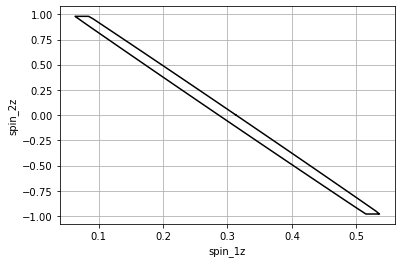

In [15]:
plt.plot(spin_ellipse.samples[0], spin_ellipse.samples[1], 'k')
plt.xlabel(spin_ellipse.keys()[0])
plt.ylabel(spin_ellipse.keys()[1])
plt.grid()

In [16]:
chi1, chi2 = np.mgrid[0:0.6:21j, -1:1:21j]
q = m2/m1
chieff = (chi1 + q * chi2)/(1+q)

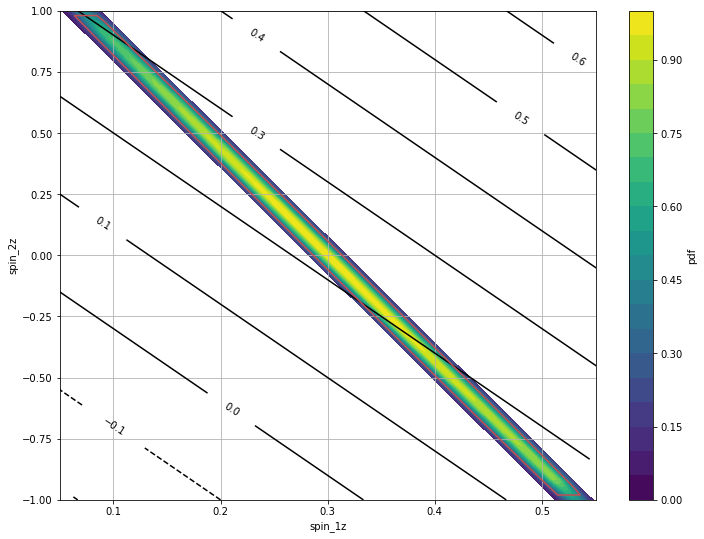

In [17]:
plt.figure(figsize=(12, 9))
plt.contourf(spin_matches.samples[0], spin_matches.samples[1], spin_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(spin_matches.keys()[0])
plt.ylabel(spin_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(spin_ellipse.samples[0], spin_ellipse.samples[1], 'r')
chi_cont = plt.contour(chi1, chi2, chieff, colors='k', levels=np.arange(-1,1,0.1))
plt.clabel(chi_cont, fontsize=10)
plt.xlim([0.05, 0.55])
plt.ylim([-1,1])
plt.grid()

## Masses

In [18]:
dx_directions = ['mass_1', 'mass_2']

In [19]:
g_mass = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [20]:
mass_ellipse = generate_ellipse(g_mass)

In [21]:
mass_matches = match_grid(g_mass, lim = 1.3, npts=21)

In [22]:
mass_prob = np.exp(-snr**2/2 * (1 - mass_matches['match']))

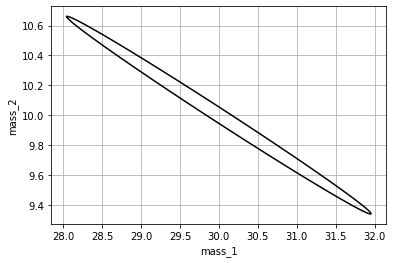

In [23]:
plt.plot(mass_ellipse.samples[0], mass_ellipse.samples[1], 'k')
plt.xlabel(mass_ellipse.keys()[0])
plt.ylabel(mass_ellipse.keys()[1])
plt.grid()

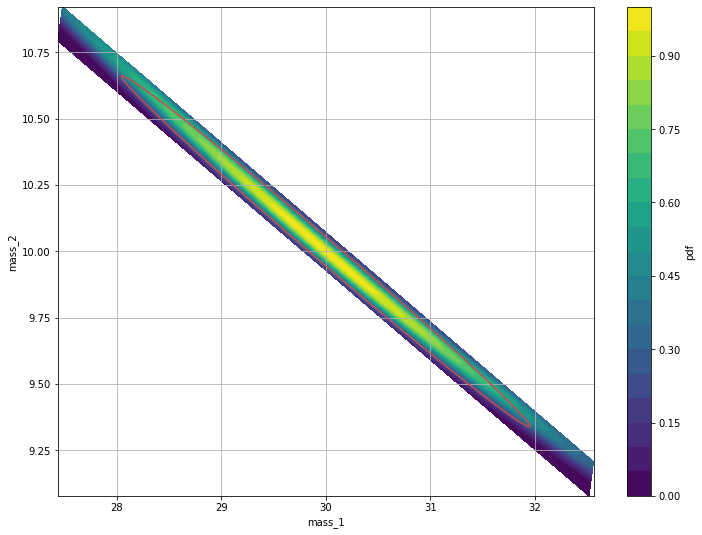

In [24]:
plt.figure(figsize=(12, 9))
plt.contourf(mass_matches.samples[0], mass_matches.samples[1], mass_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(mass_matches.keys()[0])
plt.ylabel(mass_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mass_ellipse.samples[0], mass_ellipse.samples[1], 'r')
#chi_cont = plt.contour(chi1, chi2, chieff, colors='k', levels=np.arange(-1,1,0.1))
#plt.xlim([0.05, 0.55])
#plt.ylim([-1,1])
plt.grid()

### Repeat with chirp mass and eta

In [25]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'spin_1z': s1z,
          'spin_2z': s2z
        }

In [26]:
dx_directions = ['chirp_mass', 'symmetric_mass_ratio']

In [27]:
g_mceta = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [28]:
mceta_ellipse = generate_ellipse(g_mceta)

mceta_matches = match_grid(g_mceta, lim = 1.3, npts=21)
mceta_prob = np.exp(-snr**2/2 * (1 - mceta_matches['match']))

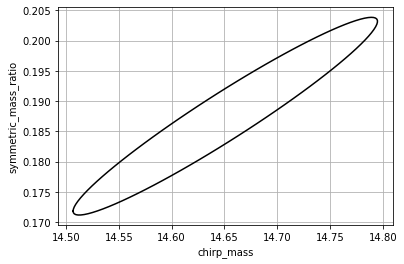

In [29]:
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'k')
plt.xlabel(mceta_ellipse.keys()[0])
plt.ylabel(mceta_ellipse.keys()[1])
plt.grid()

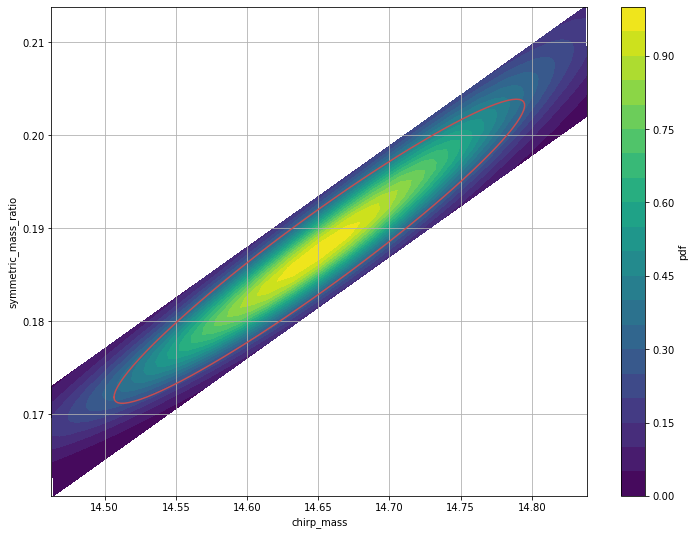

In [30]:
plt.figure(figsize=(12, 9))
plt.contourf(mceta_matches.samples[0], mceta_matches.samples[1], mceta_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(mceta_matches.keys()[0])
plt.ylabel(mceta_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'r')
plt.grid()

In [31]:
mass1 = conversions.mass1_from_mchirp_eta(mceta_matches['chirp_mass'], mceta_matches['symmetric_mass_ratio'])
mass2 = conversions.mass2_from_mchirp_eta(mceta_matches['chirp_mass'], mceta_matches['symmetric_mass_ratio'])

mass1_el = conversions.mass1_from_mchirp_eta(mceta_ellipse['chirp_mass'], mceta_ellipse['symmetric_mass_ratio'])
mass2_el = conversions.mass2_from_mchirp_eta(mceta_ellipse['chirp_mass'], mceta_ellipse['symmetric_mass_ratio'])

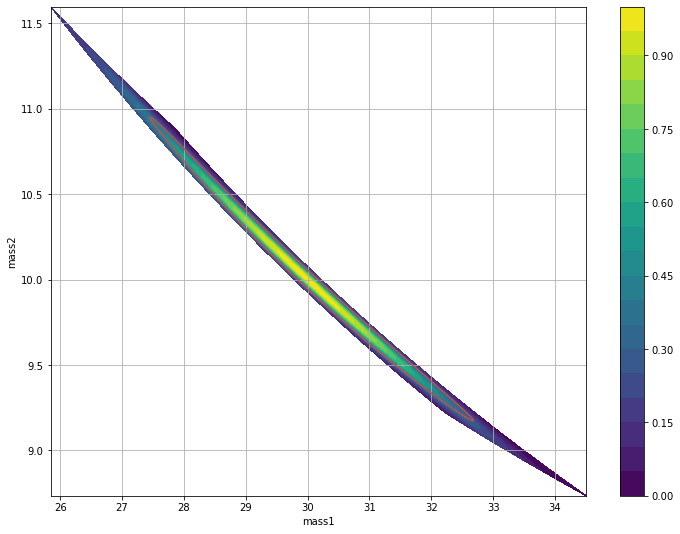

In [32]:
plt.figure(figsize=(12, 9))
plt.contourf(mass1, mass2, mceta_prob, levels=np.linspace(0, 1, 21))
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.plot(mass1_el, mass2_el, 'r')
plt.colorbar()
plt.grid()

## Three dimensions with projection

Note: we are using "chi_eff", but that's just putting the same spin on both BHs, so probably don't need to worry about the fact that it's not the best measured spin direction.

In [33]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'chi_eff':chi_eff
        }

In [34]:
dx_directions = ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']

In [35]:
g_3d = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

### Chirp mass -- eta

In [36]:
dx_keep = ['chirp_mass','symmetric_mass_ratio']


2d calculation

In [37]:
g_mceta = metric.find_metric_and_eigendirections(params, dx_keep, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [38]:
mceta_ellipse = generate_ellipse(g_mceta)

mceta_matches = match_grid(g_mceta, lim = 1.3, npts=21)
mceta_prob = np.exp(-snr**2/2 * (1 - mceta_matches['match']))

3d calculation

In [39]:
g_3d.project_metric(dx_keep)
mceta_3d_ellipse = generate_ellipse(g_3d, projected=True)

mceta_proj_matches = match_grid(g_3d, projected=True, lim = 1.1, npts=21)
mceta_proj_prob = np.exp(-snr**2/2 * (1 - mceta_proj_matches['match']))

Compare regions

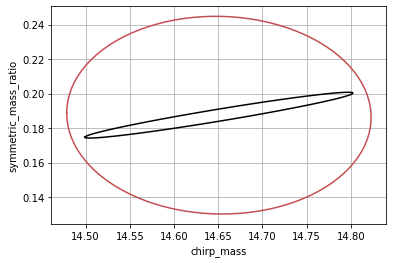

In [40]:
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'k')
plt.plot(mceta_3d_ellipse.samples[0], mceta_3d_ellipse.samples[1], 'r')
plt.xlabel(mceta_3d_ellipse.keys()[0])
plt.ylabel(mceta_3d_ellipse.keys()[1])
plt.grid()

Check matches

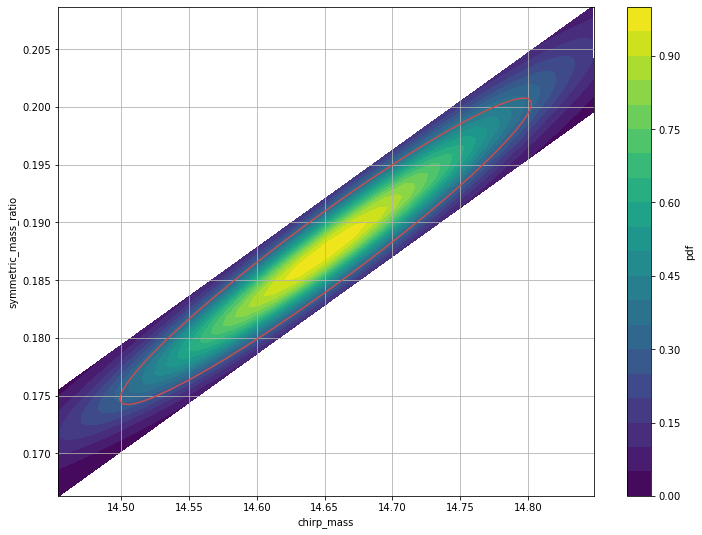

In [41]:
plt.figure(figsize=(12, 9))
plt.contourf(mceta_matches.samples[0], mceta_matches.samples[1], mceta_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(mceta_matches.keys()[0])
plt.ylabel(mceta_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'r')
plt.grid()

In [43]:
npts = 21

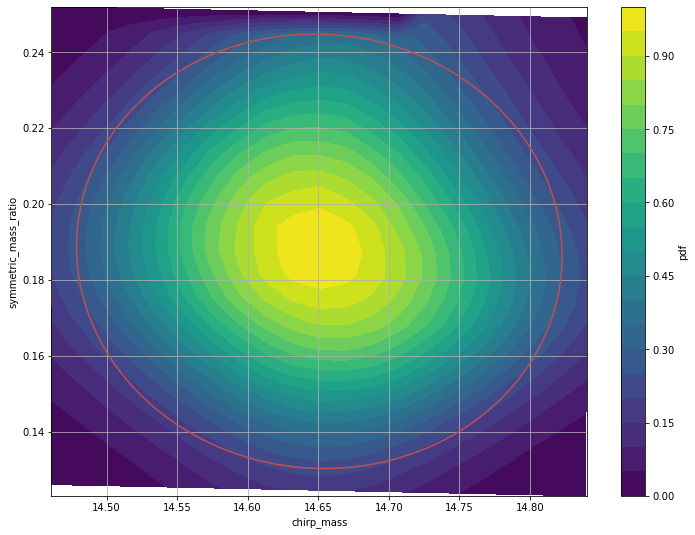

In [44]:
plt.figure(figsize=(12, 9))
plt.contourf(mceta_proj_matches.samples[0].reshape([npts,npts]), 
             mceta_proj_matches.samples[1].reshape([npts,npts]), 
             mceta_proj_prob.reshape([npts,npts]), 
             levels=np.linspace(0, 1, 21))
plt.xlabel(mceta_proj_matches.keys()[0])
plt.ylabel(mceta_proj_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mceta_3d_ellipse.samples[0], mceta_3d_ellipse.samples[1], 'r')
plt.grid()

### eta -- chi eff

In [45]:
dx_keep = ['symmetric_mass_ratio', 'chi_eff']

In [46]:
g_eta_chi = metric.find_metric_and_eigendirections(params, dx_keep, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

eta_chi_ellipse = generate_ellipse(g_eta_chi)

eta_chi_matches = match_grid(g_eta_chi, lim = 1.3, npts=21)
eta_chi_prob = np.exp(-snr**2/2 * (1 - eta_chi_matches['match']))

In [47]:
g_3d.project_metric(dx_keep)
eta_chi_3d_ellipse = generate_ellipse(g_3d, projected=True)

eta_chi_proj_matches = match_grid(g_3d, projected=True, lim = 1.1, npts=21)
eta_chi_proj_prob = np.exp(-snr**2/2 * (1 - eta_chi_proj_matches['match']))

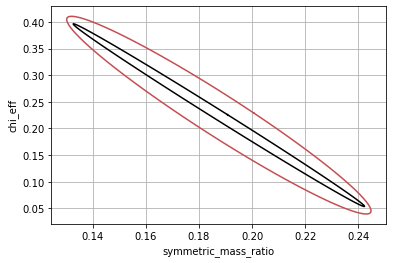

In [48]:
plt.plot(eta_chi_ellipse.samples[0], eta_chi_ellipse.samples[1], 'k')
plt.plot(eta_chi_3d_ellipse.samples[0], eta_chi_3d_ellipse.samples[1], 'r')
plt.xlabel(eta_chi_3d_ellipse.keys()[0])
plt.ylabel(eta_chi_3d_ellipse.keys()[1])
plt.grid()

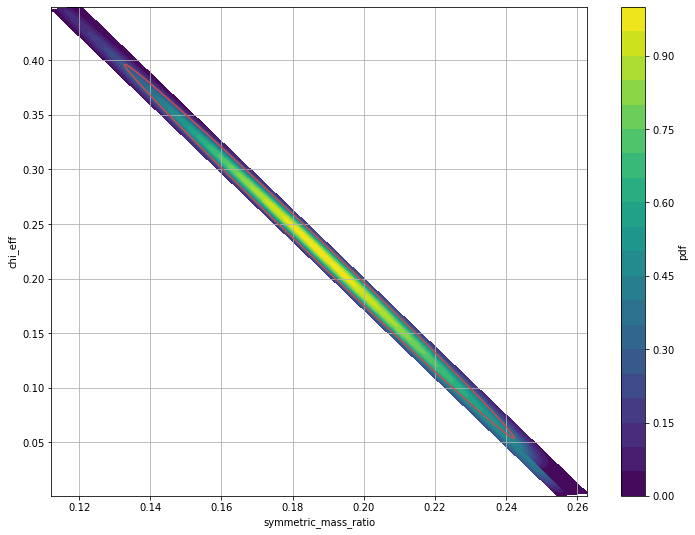

In [49]:
plt.figure(figsize=(12, 9))
plt.contourf(eta_chi_matches.samples[0], eta_chi_matches.samples[1], eta_chi_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(eta_chi_matches.keys()[0])
plt.ylabel(eta_chi_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(eta_chi_ellipse.samples[0], eta_chi_ellipse.samples[1], 'r')
plt.grid()

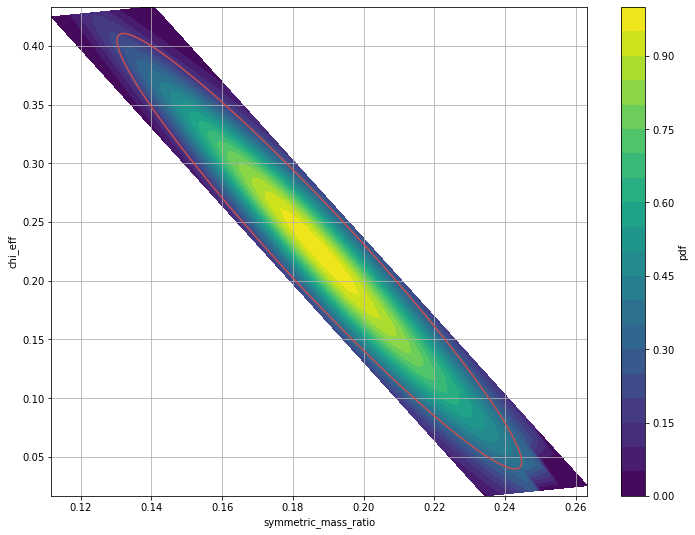

In [50]:
plt.figure(figsize=(12, 9))
plt.contourf(eta_chi_proj_matches.samples[0].reshape([npts,npts]), 
             eta_chi_proj_matches.samples[1].reshape([npts,npts]), 
             eta_chi_proj_prob.reshape([npts,npts]), 
             levels=np.linspace(0, 1, 21))
plt.xlabel(eta_chi_proj_matches.keys()[0])
plt.ylabel(eta_chi_proj_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(eta_chi_3d_ellipse.samples[0], eta_chi_3d_ellipse.samples[1], 'r')
plt.grid()

### chirp mass -- chi eff

In [51]:
dx_keep = ['chirp_mass', 'chi_eff']

In [52]:
g_mc_chi = metric.find_metric_and_eigendirections(params, dx_keep, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

mc_chi_ellipse = generate_ellipse(g_mc_chi)

mc_chi_matches = match_grid(g_mc_chi, lim = 1.3, npts=21)
mc_chi_prob = np.exp(-snr**2/2 * (1 - mc_chi_matches['match']))

In [53]:
g_3d.project_metric(dx_keep)
mc_chi_3d_ellipse = generate_ellipse(g_3d, projected=True)

In [54]:
mc_chi_proj_matches = match_grid(g_3d, projected=True, lim = 1.1, npts=21)
mc_chi_proj_prob = np.exp(-snr**2/2 * (1 - mc_chi_proj_matches['match']))

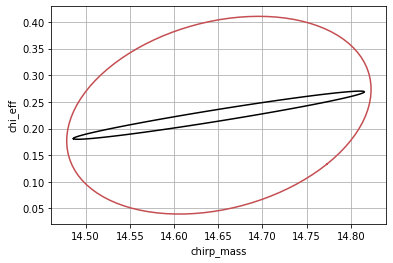

In [55]:
plt.plot(mc_chi_ellipse.samples[0], mc_chi_ellipse.samples[1], 'k')
plt.plot(mc_chi_3d_ellipse.samples[0], mc_chi_3d_ellipse.samples[1], 'r')
plt.xlabel(mc_chi_3d_ellipse.keys()[0])
plt.ylabel(mc_chi_3d_ellipse.keys()[1])
plt.grid()

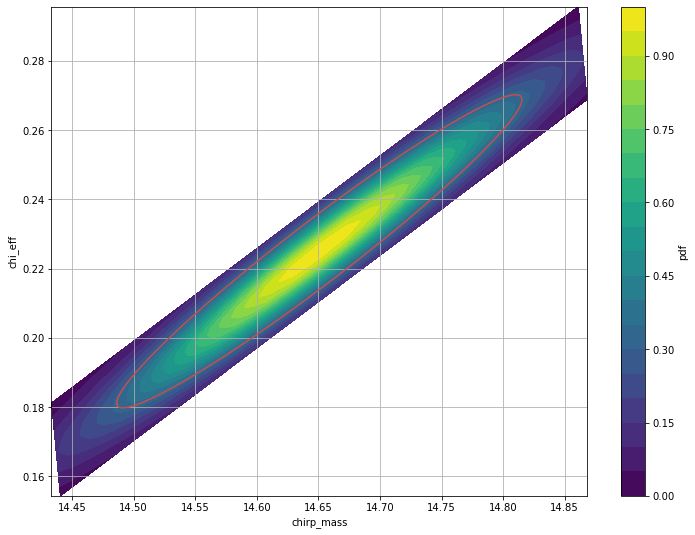

In [56]:
plt.figure(figsize=(12, 9))
plt.contourf(mc_chi_matches.samples[0], mc_chi_matches.samples[1], mc_chi_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(mc_chi_matches.keys()[0])
plt.ylabel(mc_chi_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mc_chi_ellipse.samples[0], mc_chi_ellipse.samples[1], 'r')
plt.grid()

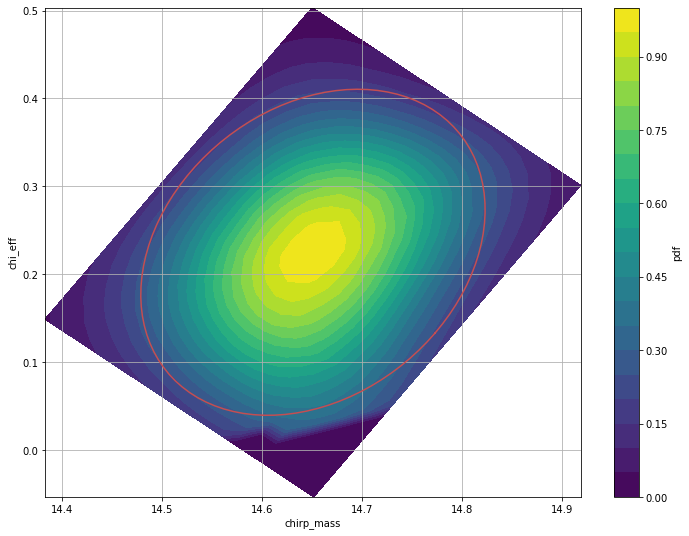

In [57]:
plt.figure(figsize=(12, 9))
plt.contourf(mc_chi_proj_matches.samples[0].reshape([npts,npts]), 
             mc_chi_proj_matches.samples[1].reshape([npts,npts]), 
             mc_chi_proj_prob.reshape([npts,npts]), 
             levels=np.linspace(0, 1, 21))
plt.xlabel(mc_chi_proj_matches.keys()[0])
plt.ylabel(mc_chi_proj_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mc_chi_3d_ellipse.samples[0], mc_chi_3d_ellipse.samples[1], 'r')
plt.grid()